In [1]:
import pandas as pd
import re
import os
from collections import Counter
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm

In [2]:
# DATASET_DIR = "dataset"
# TRAIN_DATA = os.path.join(DATASET_DIR, "train.csv")
# VAL_DATA = os.path.join(DATASET_DIR, "validation.csv")
# CHUNKSIZE = 50000
# output_path = os.path.join(DATASET_DIR, "cleaned_data.csv")

In [3]:
DATASET_DIR = "dataset"
TRAIN_DATA = os.path.join(DATASET_DIR, "gutenberg.csv")
CHUNKSIZE = 10000
output_path = os.path.join(DATASET_DIR, "cleaned_data.csv")

# Cleaning Data

In [4]:
df = pd.read_csv(TRAIN_DATA)
df.head(10)

,text
0,You will rejoice to hear that no disaster has ...
1,"This text is a combination of etexts, one from..."
2,Walt Whitmanhas somewhere a fine and just dist...
3,Alice was beginning to get very tired of sitti...
4,Mr. Utterson the lawyer was a man of a rugged ...
5,"“The Signora had no business to do it,” said M..."
6,Who that cares much to know the history of man...
7,“Ne raillons pas les fous; leur folie dure plu...
8,"""Christmaswon't be Christmas without any \npre..."
9,"3 May. Bistritz.—Left Munich at 8:35P. M., on ..."


Allowing pattern for 
- normal letter a-z A-Z
- digits 0-9
- common punctuation ,.!?\'
- whitespace

In [5]:
# this is first detection for looking the wierd character but could be still meaningful.
allowed_pattern = re.compile(r"[a-zA-Z0-9,.!?'\s`]")

char_counter = Counter()

# the dataset has ; in the header (so use the seper)
for chunk in tqdm(pd.read_csv(TRAIN_DATA, chunksize=CHUNKSIZE), desc="Scanning characters"):
    chunk = chunk.dropna()
    texts = chunk["text"].astype(str)
    joined = " ".join(texts)
    char_counter.update(joined)
    
# Extract weird characters
weird_chars = {c: n for c, n in char_counter.items() if not allowed_pattern.match(c)}

print("Weird Characters Detected")
for c, count in weird_chars.items():
    print(repr(c), ":", count)

Scanning characters: 1it [00:54, 54.10s/it]

Weird Characters Detected
';' : 1861810
'—' : 1673001
'’' : 1894102
'-' : 1816753
':' : 439485
'(' : 143078
')' : 143117
'“' : 2262888
'”' : 2197644
'æ' : 9623
'‘' : 299481
'ê' : 9259
'ô' : 6251
'é' : 66150
'[' : 147824
']' : 147759
'è' : 14197
'*' : 17063
'£' : 3203
'$' : 4546
'œ' : 5656
'â' : 7038
'&' : 9238
'{' : 12094
'}' : 12071
'à' : 5980
'ù' : 333
'ç' : 5137
'ö' : 7364
'ä' : 3334
'…' : 12805
'û' : 1969
'À' : 141
'î' : 1886
'Ç' : 303
'á' : 11244
'É' : 1959
'"' : 3770107
'ë' : 2772
'ü' : 5459
'ï' : 3754
'ì' : 128
'ō' : 3117
'½' : 902
'+' : 1543
'Λ' : 22
'Α' : 37
'Ξ' : 2
'Μ' : 20
'Γ' : 18
'Ε' : 19
'Æ' : 1471
'/' : 1479
'‐' : 1300
'Œ' : 156
'Ü' : 87
'È' : 35
'ò' : 330
'ā' : 1996
'ñ' : 9188
'ó' : 3712
'ú' : 2654
'✠' : 3
'†' : 54
'%' : 113
'°' : 2184
'ſ' : 4929
'•' : 6
'̸' : 2
'′' : 281
'″' : 38
'–' : 19695
'í' : 6384
'Ú' : 12
'Á' : 481
'|' : 10895
'_' : 1321
'Ã' : 289
'¦' : 12
'=' : 1484
'@' : 70
'#' : 4637
'>' : 153
'ã' : 322
'・' : 3
'ŭ' : 290
'º' : 26
'Θ' : 10
'ε' : 817
'ο' : 1106


After detected the candidates of meaningless symbols, We choosed to keep some symbols:
1. Quotation Marks
- "
- “
- ”
- ‘ valid opening quote
- ’ apostrophe in don’t, Lily’s

2. Hyphens & Dashes
- `-` normal hyphen (well-known)
- – en-dash

3. Story Punctuation
- .
- ,
- ?
- !
- :
- ;
- …  ellipsis
- () parentheses

4. another symbol
- &
- /


Cleaning from the unwanted symbol and also reduce the over whitespace and \n

In [6]:
CLEAN_PATTERN = re.compile(r"[^a-zA-Z0-9\s\"“”‘’\-\–\.\,\?\!\:\;\…\(\)&/]+")
import unicodedata
def clean_text(text):
    if pd.isna(text) or text is None:
        return ""

    # Ensure string
    text = str(text)

    # Remove Unicode replacement characters (�)
    text = text.replace("\ufffd", "")

    # Remove invalid surrogate unicode ranges
    text = re.sub(r"[\ud800-\udfff]", "", text)

    # Remove other control characters except common whitespace
    text = re.sub(r"[\x00-\x08\x0B\x0C\x0E-\x1F\x7F]", "", text)

    # Apply your original cleaning pattern
    text = CLEAN_PATTERN.sub("", text)

    # Normalize weird unicode (e.g., curly quotes → normal quotes)
    text = unicodedata.normalize("NFKC", text)

    # Replace whitespace types with space
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\r', ' ')

    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

In [7]:
gc.enable()
gc.collect()

30

export to clean.csv

In [8]:

BUFFER_SIZE = 10000

reader = pd.read_csv(TRAIN_DATA, chunksize=CHUNKSIZE,encoding="utf-8",encoding_errors="ignore",dtype=str)

pd.DataFrame(columns=["text"]).to_csv(output_path, index=False)

buffer = []

for chunk in tqdm(reader, desc="Cleaning"):
    chunk = chunk.dropna(how="all")

    if chunk.shape[1] > 1:
        texts = chunk.astype(str).agg(" ".join, axis=1)
    else:
        texts = chunk.iloc[:, 0].astype(str)

    cleaned = texts.apply(clean_text)
    cleaned = cleaned[cleaned.str.len() > 0]  

    buffer.extend(cleaned.tolist())

    if len(buffer) >= BUFFER_SIZE:
        pd.DataFrame({"text": buffer}).to_csv(
            output_path, mode="a", header=False, index=False
        )
        buffer = [] 

if buffer:
    pd.DataFrame({"text": buffer}).to_csv(
        output_path, mode="a", header=False, index=False
    )

print("Cleaning completed!")

Cleaning: 1it [01:16, 76.26s/it]


Cleaning completed!


In [9]:
del cleaned,buffer

In [10]:
# reader = pd.read_csv(VAL_DATA, chunksize=CHUNKSIZE)
# output_path = "cleaned_output.csv"

# pd.DataFrame(columns=["text"]).to_csv(output_path, index=False)

# buffer = []

# for chunk in tqdm(reader, desc="Cleaning"):
#     chunk = chunk.dropna(how="all")

#     if chunk.shape[1] > 1:
#         texts = chunk.astype(str).agg(" ".join, axis=1)
#     else:
#         texts = chunk.iloc[:, 0].astype(str)

#     cleaned = texts.apply(clean_text)
#     cleaned = cleaned[cleaned.str.len() > 0]  

#     buffer.extend(cleaned.tolist())

#     if len(buffer) >= BUFFER_SIZE:
#         pd.DataFrame({"text": buffer}).to_csv(
#             output_path, mode="a", header=False, index=False
#         )
#         buffer = [] 

# if buffer:
#     pd.DataFrame({"text": buffer}).to_csv(
#         output_path, mode="a", header=False, index=False
#     )

# print("Cleaning completed!")

# Cleaned Preview

In [11]:
CLEANED_DATASET = output_path
word_counter = Counter()

In [12]:
del df,reader
gc.collect()

15

In [13]:
new_df = pd.read_csv(CLEANED_DATASET, nrows=5)
new_df.head(5)

,text
0,You will rejoice to hear that no disaster has ...
1,"This text is a combination of etexts, one from..."
2,Walt Whitmanhas somewhere a fine and just dist...
3,Alice was beginning to get very tired of sitti...
4,Mr. Utterson the lawyer was a man of a rugged ...


In [14]:
gc.collect()

0

In [15]:
word_counter = Counter()
CHUNKSIZE = 5000

reader = pd.read_csv(CLEANED_DATASET, chunksize=CHUNKSIZE)

for chunk in tqdm(reader, desc="Counting"):
    for text in chunk["text"].astype(str):
        word_counter.update(word for word in text.lower().split())

# Get top N
top_n = 50
for word, freq in word_counter.most_common(top_n):
    print(f"{word}: {freq}")

Counting: 1it [00:55, 55.94s/it]


the: 14266617
and: 7859407
of: 7031178
to: 6685016
a: 5590943
in: 3905341
he: 3490796
was: 3218146
i: 3127700
that: 2848180
his: 2668667
had: 2116578
it: 2112115
with: 2110132
as: 1904578
her: 1889208
for: 1856555
she: 1831134
you: 1807655
at: 1585824
not: 1432601
but: 1395993
on: 1391769
is: 1305501
be: 1238308
have: 1140955
my: 1122003
they: 1011211
by: 977973
from: 975227
all: 919968
this: 903320
which: 893849
were: 889228
him: 830019
so: 816042
said: 793484
one: 747376
an: 732942
would: 732479
when: 682575
if: 659000
we: 657206
me: 637389
been: 627867
or: 620486
no: 618809
there: 616966
their: 595204
what: 583085


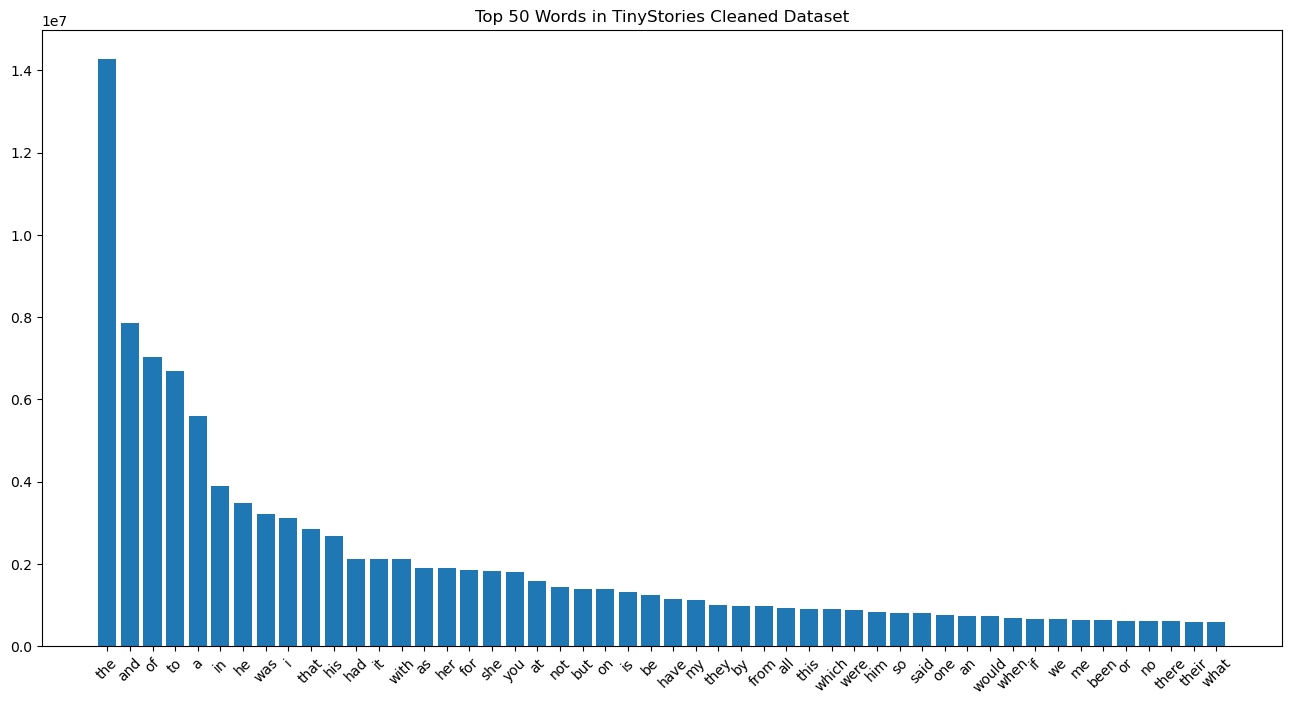

In [16]:
top_words = word_counter.most_common(50)
words, counts = zip(*top_words)

plt.figure(figsize=(16,8))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 50 Words in TinyStories Cleaned Dataset")
plt.show()
